In [1]:
from printrun.printcore import printcore
from printrun import gcoder
import time
import pyvisa
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Connect to Devices

##### Scope

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x1AB1::0x044D::DHO8A254404063::INSTR')
print(f'Scope: {scope.query('*IDN?')}')

Scope: RIGOL TECHNOLOGIES,DHO804,DHO8A254404063,00.01.01



##### 3D Printer

In [3]:
# Connect to printer
p = printcore("COM3", 115200)

## Set Up

##### Scope

In [4]:
# General Scope Setup
scope.write(":TIM:SCAL 0.00002")  # Set timebase to 1000 us/div

19

In [5]:
# Transmitter
scope.write(":CHAN1:OFFS 0")
scope.write(":CHAN1:SCAL 3.5")    # Set CH1 voltage scale to 3.5V/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
scope.write(":TRIG:LEV 5.2")    # Set trigger level to 0.5V

15

In [6]:
# Receiver
scope.write(":CHAN2:OFFS 0")
scope.write(":CHAN2:SCAL 0.02")    # Set CH1 voltage scale to 20mV/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
#scope.write(":TRIG:LEV ")    # Set trigger level to 0.5V

13

##### 3D Printer

In [7]:
p.send("G91") # Set relative positioning mode. THIS MUST BE DONE FIRST OR PRINTER COULD ACT WEIRD?

In [8]:
p.send("G28 X0 Y0") # Home only X and Y

In [9]:
p.send("G28 Z0") # Home only Z

In [10]:
p.send("G1 Z440 F12000") # Move Z down to bottom

In [11]:
p.send("G1 X150 Y100 F12000") # Center X and Y

## Measurement Function

In [12]:
def measure_scope_vpp():
    measurements = np.array([float(scope.query(":MEAS:VPP? CHAN2")) for _ in range(10)])
    meas_avg = np.average(sorted(measurements)[5:])
    return meas_avg

## 3D Printer Movement and Data Acquisition

In [16]:
p.send("G1 Z-10 F12000")

In [38]:
p.send("G1 X-1 F1000")

In [26]:
p.send("G1 Y2 F1000")

In [ ]:
# Find peak (center)
p.send("G1 X-5 Y-5 F1000")
(x_max, y_max) = (0,0)
max_measure = 0
for i in tqdm(range(10)):
    for j in tqdm(range(10)):
        measurement = measure_scope_vpp()
        if measurement > max_measure:
            max_measure = measurement
            x_max = j
            y_max = i
        p.send("G1 X1 F1000")
        time.sleep(0.5)
    p.send("G1 X-10 Y1 F1000")
    time.sleep(10)
p.send("G1 Y-10 F1000")
time.sleep(5)
p.send(f"G1 X{x_max} Y{y_max} F1000")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
p.send("G1 Z-10 F1000")

In [ ]:
z_planes = 1
y_points = 27
x_points = 27
x_range = 81 # mm
y_range = 81 # mm
x_movement = x_range / x_points 
y_movement = y_range / y_points
measurements = np.zeros((z_planes, y_points, x_points))
p.send(f'G1 X-{x_range/2} Y-{y_range/2} F1000')
time.sleep(5)
for i in tqdm(range(z_planes)): # Z
    for j in tqdm(range(y_points)): # Y 
        for k in tqdm(range(x_points)): # X
            # Measure here
            measurements[i,j,k] = measure_scope_vpp()
            p.send(f"G1 X{x_movement} F1000")
            time.sleep(0.15)
        # Measure last x point 
        p.send(f"G1 X-{x_range} Y{y_movement} F1000")
        time.sleep(7)
    # p.send(f"G1 Y-{y_range} Z10 F3000")
    time.sleep(5)
# p.send(f'G1 X{x_range/2} Y{y_range/2} Z{z_planes * 10} F12000')
# p.send(f'G1 X-{x_range/2} Y-{y_range/2} F12000')
p.send(f'G1 X{x_range/2} Y-{y_range/2} F1000') # Moves back to center
print(measurements)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

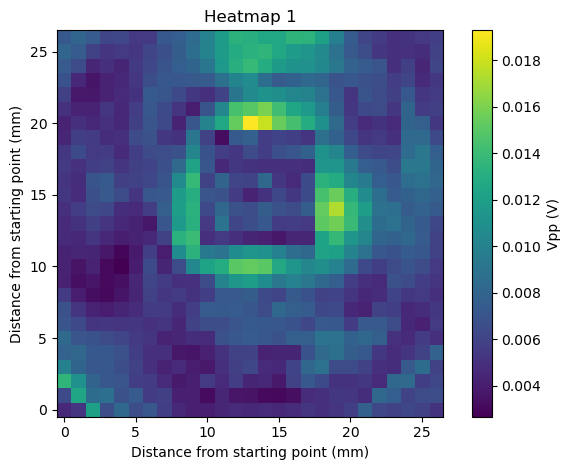

In [ ]:
# Plot and save

img1 = plt.imshow(measurements[0], cmap="viridis", interpolation="nearest", origin="lower")
plt.title("Heatmap 1")
plt.xlabel("Distance from starting point (mm)")
plt.ylabel("Distance from starting point (mm)")

# Add colorbars
plt.colorbar(img1, label="Vpp (V)")

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Save data
# np.savetxt("./images/4_17_25_square_new_Tx_3mm.csv", measurements[0], delimiter=",", fmt="%.6f")  # fmt controls number formatting
np.savetxt("./images/4_17_25_square_new_Tx_3mm.csv", measurements[0], delimiter=",")  # fmt controls number formatting

In [73]:
p.send("G1 Y5 F1000")

In [132]:
p.send("G1 Z-10 F12000")